発想を変え、晴天時のデータのみを使い、地下水への浸透を利用してフィッティングを行う。

過去 n ヵ月の平均大気窒素酸化物濃度を利用する。


In [1]:
# import sys

BASEDIR = "./"

# sys.path.insert(0, "..")

## `air`から NOX 値の読みこみ


In [2]:
# 指定された局の、全期間のNOX値を抽出する。

import pandas as pd

from air import reader as airreader

stations = ["19202030", "19206010", "19441030"]

DATAPATH = BASEDIR + "air/data"

nox = None
for obs_air in stations:
    nox1 = airreader.read_NOX_ppb(DATAPATH, obs_air)
    if nox is None:
        nox = nox1
    else:
        nox = pd.merge(
            nox, nox1, left_index=True, right_index=True
        )  # on="datetime", how="inner")

# nox.index=nox.datetime
nox

,19202030,19206010,19441030
datetime,,,
2009-04-01 00:00:00+09:00,9.0,27.0,22.0
2009-04-01 01:00:00+09:00,7.0,34.0,12.0
2009-04-01 02:00:00+09:00,7.0,37.0,17.0
2009-04-01 03:00:00+09:00,8.0,24.0,35.0
2009-04-01 04:00:00+09:00,8.0,26.0,36.0
...,...,...,...
2021-03-31 19:00:00+09:00,6.0,8.0,9.0
2021-03-31 20:00:00+09:00,4.0,8.0,6.0
2021-03-31 21:00:00+09:00,4.0,10.0,6.0


In [3]:
# 欠測を補う
nox = nox.interpolate()
# nox[nox["19202030"].isnull().values]

NOX のトレンド。


2009 年より前は 1 ヵ月単位の NOX 値を使う。(全部これでもいいのかも)


In [6]:
nox2 = airreader.read_NOX_TD20231218_155555_51(
    "air/data/TD20231218_155555_51", stations
)
nox2

/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/論文2025/原稿/KM2025/air/reader.py:100: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range("2000/4/1", "2021/3/31", freq="H").tz_localize("Asia/Tokyo")


,19202030,19206010,19441030
datetime,,,
2000-04-01 00:00:00+09:00,11.0,30.0,23.0
2000-04-01 01:00:00+09:00,11.0,30.0,23.0
2000-04-01 02:00:00+09:00,11.0,30.0,23.0
2000-04-01 03:00:00+09:00,11.0,30.0,23.0
2000-04-01 04:00:00+09:00,11.0,30.0,23.0
...,...,...,...
2021-03-30 20:00:00+09:00,6.0,15.0,7.0
2021-03-30 21:00:00+09:00,6.0,15.0,7.0
2021-03-30 22:00:00+09:00,6.0,15.0,7.0


In [7]:
rows = pd.merge(nox, nox2, how="inner", on="datetime").index
nox2.loc[rows, nox2.columns] = nox.loc[rows, nox2.columns]

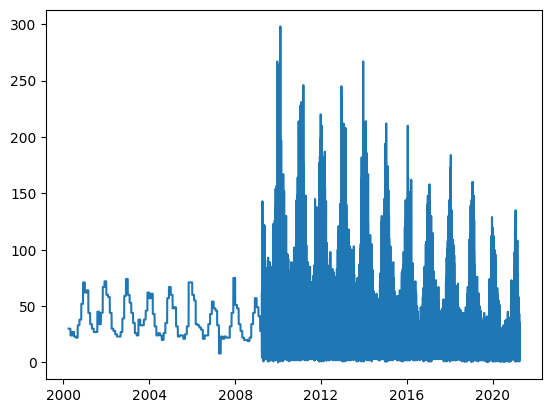

In [9]:
import matplotlib.pyplot as plt

plt.plot(nox2.index, nox2["19206010"], label="NOX")

N ヵ月の移動平均をとる。


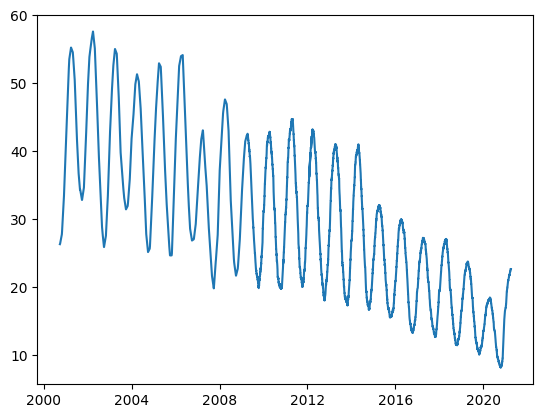

In [11]:
# Thank you Gemini

N = 6  # 6を標準とする。
days_in_month_avg = 30
window_size = N * days_in_month_avg * 24


nox3 = pd.DataFrame(index=nox2.index)
for obs_air in stations:
    # center=Trueを指定すると、移動平均の中心が現在の時刻になります。
    # center=False (デフォルト) の場合は、過去のデータのみを使って平均を計算します。
    nox3[obs_air] = nox2[obs_air].rolling(window=window_size, center=False).mean()


plt.plot(nox3.index, nox3["19206010"], label="NOX")

In [12]:
del nox, nox2

In [13]:
import scipy
import numpy as np
from dataclasses import dataclass
from typing import Union


@dataclass
class AvgStd:
    avg: Union[float, np.ndarray]
    std: Union[float, np.ndarray]


def powc(a: AvgStd, n: float):
    return AvgStd(a.avg**n, np.abs(a.std * n * a.avg ** (n - 1)))


def add3(a, b, c):
    return add(add(a, b), c)


def add(a, b):
    return AvgStd(avg=a.avg + b.avg, std=(a.std**2 + b.std**2) ** 0.5)


def div(a: AvgStd, b: AvgStd):
    cavg = a.avg / b.avg
    cstd = ((a.std / a.avg) ** 2 + (b.std / b.avg) ** 2) ** 0.5 * np.abs(cavg)
    return AvgStd(cavg, cstd)


def mul(a: AvgStd, b: AvgStd):
    cavg = a.avg * b.avg
    cstd = ((a.std / a.avg) ** 2 + (b.std / b.avg) ** 2) ** 0.5 * np.abs(cavg)
    return AvgStd(cavg, cstd)


def mulc(a: AvgStd, c: float):
    return AvgStd(a.avg * c, a.std * np.abs(c))


def neg(a):
    return mulc(a, -1)


def addc(a: AvgStd, c: float):
    return AvgStd(a.avg + c, a.std)

In [14]:
def trend_v4(w, B, a, b):
    wc, Fr, crP = w
    return B * wc / Fr + a * crP + b


def prop_of_errors_v4(w, pcov):
    c, Fr, crP = w
    dfdB = c / Fr
    dfda = crP
    dfdb = np.ones_like(crP)
    dfdv = np.array([dfdB, dfda, dfdb]).T
    x = dfdv @ pcov
    return np.sum(dfdv * x, axis=1) ** 0.5


def plot_river_content(
    cr, pred, error, pred_drain, error_drain, pred_air, error_air, title=None
):
    plt.plot(pred_drain.index, pred_drain, "b.-", label="Pred. drain")
    plt.fill_between(
        pred_drain.index,
        pred_drain - error_drain,
        pred_drain + error_drain,
        color="b",
        alpha=0.2,
        label="Pred. drain",
    )
    plt.plot(pred_air.index, pred_air, "r.-", label="Pred. air")
    plt.fill_between(
        pred_air.index,
        pred_air - error_air,
        pred_air + error_air,
        color="r",
        alpha=0.2,
        label="Pred. air",
    )
    plt.plot(pred.index, pred, "g.-", label="Pred. total")
    plt.fill_between(
        pred.index,
        pred - error,
        pred + error,
        color="g",
        alpha=0.2,
        label="Pred. total",
    )
    plt.plot(cr, ".-k", label="Observed")
    plt.ylim(0, 2)
    if title is not None:
        plt.title(title)
    plt.xlabel("月")
    plt.ylabel("窒素濃度/ppm")
    plt.legend()


def plot_river_composition(
    pred, error, pred_air, error_air, ylabel="大気由来成分 %", title=None
):
    total = AvgStd(avg=pred, std=error)
    air = AvgStd(
        avg=pred_air,
        std=error_air,
    )

    composition = mulc(div(air, total), 100)

    plt.plot(composition.avg, ".-", label=f"Avg. {np.mean(composition.avg):.1f}%")
    plt.fill_between(
        composition.avg.index,
        composition.avg - composition.std,
        composition.avg + composition.std,
        # color="b",
        alpha=0.2,
        # label="Air",
    )
    if title is not None:
        plt.title(title)
    plt.ylim(0, 100)
    plt.xlabel("月")
    plt.ylabel(ylabel)
    # plt.legend()

/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:58: UserWarning: Glyph 26157 (\N{CJK UNIFIED IDEOGRAPH-662D}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure3{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:58: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure3{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:58: UserWarning: Glyph 27211 (\N{CJK UNIFIED IDEOGRAPH-6A4B}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure3{panel}.pdf")
/Users/matto/Library/Caches/pypoetry/virtualenvs/km2025-BcinpgeY-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26157 (\N{CJK UNIFIED IDEOGRAPH-662D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/matto/Library/Caches/pypoetry/virtualenvs/km2025-BcinpgeY-py3.11/lib/python3.11/site-packa

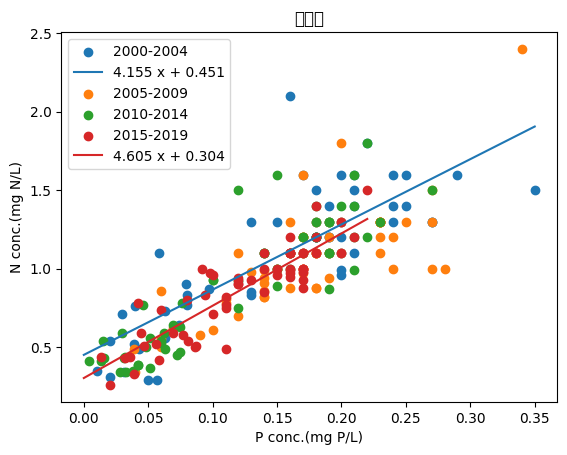

ic| 大気N_delay:                            value  19202030
               datetime                                  
               2000-04-19 12:00:00+09:00   1.60       NaN
               2000-05-10 12:00:00+09:00   1.30       NaN
               2000-06-07 12:00:00+09:00   1.50       NaN
               2000-07-05 12:00:00+09:00   1.40       NaN
               2000-08-02 12:00:00+09:00   0.29       NaN
               ...                          ...       ...
               2021-11-04 12:00:00+09:00   0.97       NaN
               2021-12-02 12:00:00+09:00   1.00       NaN
               2022-01-06 12:00:00+09:00   1.00       NaN
               2022-02-03 12:00:00+09:00   1.10       NaN
               2022-03-03 12:00:00+09:00   0.94       NaN
               
               [264 rows x 2 columns]
ic| B: np.float64(0.008289852239384273)
    a: np.float64(3.98846754478008)
    b: np.float64(0.35277183701844966)
ic| np.corrcoef(crN1, pred): array([[1.        , 0.85276936],
               

(264,) (264,)


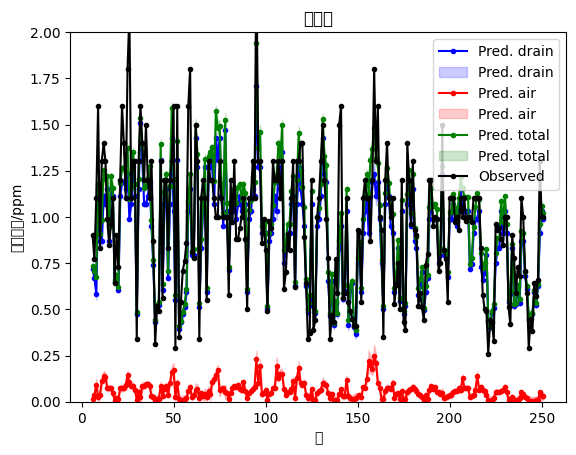

/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:148: UserWarning: Glyph 27827 (\N{CJK UNIFIED IDEOGRAPH-6CB3}) missing from font(s) DejaVu Sans.
  fig.savefig(f"FigureS2{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:148: UserWarning: Glyph 24029 (\N{CJK UNIFIED IDEOGRAPH-5DDD}) missing from font(s) DejaVu Sans.
  fig.savefig(f"FigureS2{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:148: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) DejaVu Sans.
  fig.savefig(f"FigureS2{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:148: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  fig.savefig(f"FigureS2{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:148: UserWarning: Glyph 28611 (\N{CJK UNIFIED IDEOGRAPH-6FC3}) missing from font(s

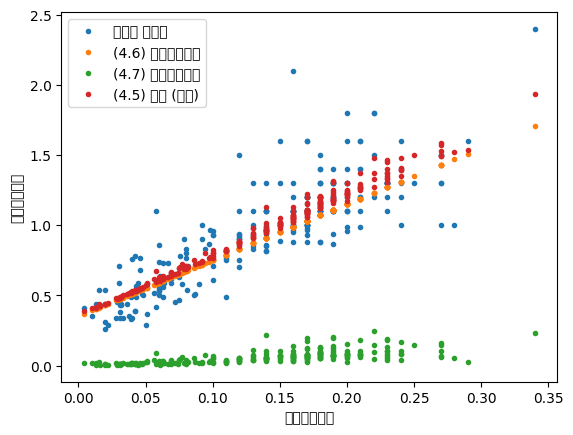

/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:164: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure6{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:164: UserWarning: Glyph 27671 (\N{CJK UNIFIED IDEOGRAPH-6C17}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure6{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:164: UserWarning: Glyph 30001 (\N{CJK UNIFIED IDEOGRAPH-7531}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure6{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:164: UserWarning: Glyph 26469 (\N{CJK UNIFIED IDEOGRAPH-6765}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure6{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:164: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missin

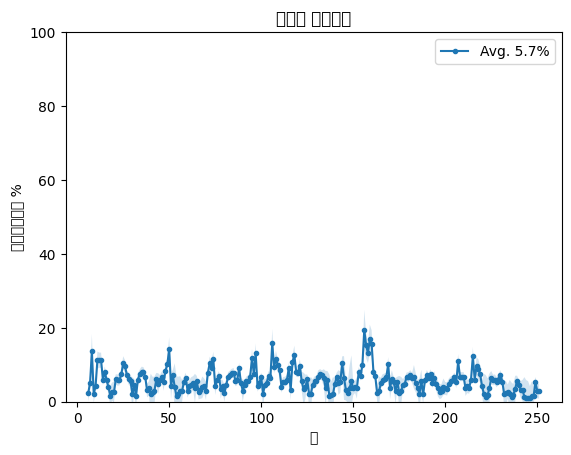

/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:58: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure3{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:58: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure3{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:58: UserWarning: Glyph 27211 (\N{CJK UNIFIED IDEOGRAPH-6A4B}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure3{panel}.pdf")
/Users/matto/Library/Caches/pypoetry/virtualenvs/km2025-BcinpgeY-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/matto/Library/Caches/pypoetry/virtualenvs/km2025-BcinpgeY-py3.11/lib/python3.11/site-packa

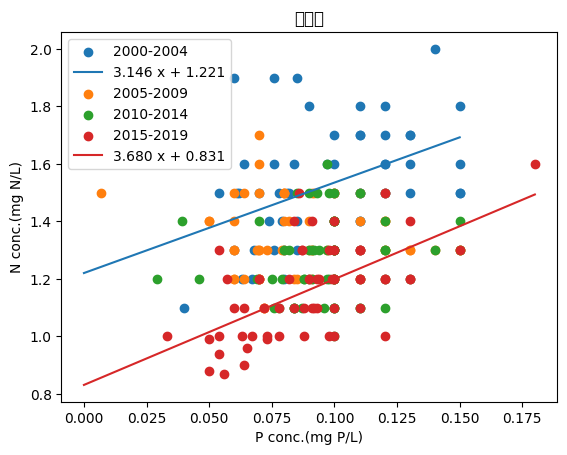

ic| 大気N_delay:                            value  19206010
               datetime                                  
               2000-04-19 14:00:00+09:00    1.7       NaN
               2000-05-10 13:00:00+09:00    1.6       NaN
               2000-06-07 13:00:00+09:00    1.6       NaN
               2000-07-05 13:00:00+09:00    1.7       NaN
               2000-08-02 13:00:00+09:00    1.4       NaN
               ...                          ...       ...
               2021-11-04 13:00:00+09:00    1.0       NaN
               2021-12-02 13:00:00+09:00    1.1       NaN
               2022-01-06 13:00:00+09:00    1.1       NaN
               2022-02-03 13:00:00+09:00    1.1       NaN
               2022-03-03 14:00:00+09:00    1.1       NaN
               
               [264 rows x 2 columns]
ic| B: np.float64(0.01657800990859324)
    a: np.float64(2.1515262040023377)
    b: np.float64(0.946007937395798)
ic| np.corrcoef(crN1, pred): array([[1.        , 0.65392136],
                

(264,) (264,)


/Users/matto/Library/Caches/pypoetry/virtualenvs/km2025-BcinpgeY-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31378 (\N{CJK UNIFIED IDEOGRAPH-7A92}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/matto/Library/Caches/pypoetry/virtualenvs/km2025-BcinpgeY-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32032 (\N{CJK UNIFIED IDEOGRAPH-7D20}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/matto/Library/Caches/pypoetry/virtualenvs/km2025-BcinpgeY-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28611 (\N{CJK UNIFIED IDEOGRAPH-6FC3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/matto/Library/Caches/pypoetry/virtualenvs/km2025-BcinpgeY-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing 

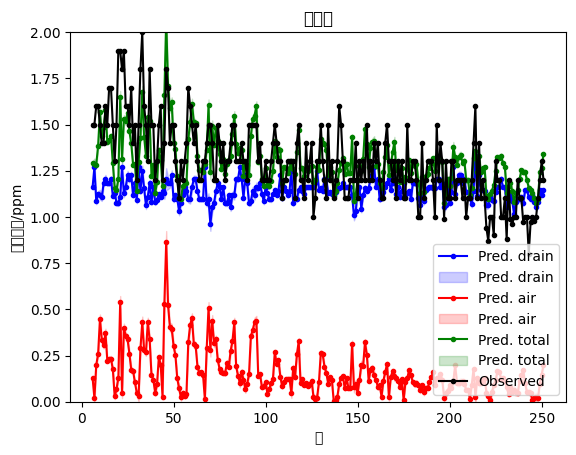

/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:148: UserWarning: Glyph 27827 (\N{CJK UNIFIED IDEOGRAPH-6CB3}) missing from font(s) DejaVu Sans.
  fig.savefig(f"FigureS2{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:148: UserWarning: Glyph 24029 (\N{CJK UNIFIED IDEOGRAPH-5DDD}) missing from font(s) DejaVu Sans.
  fig.savefig(f"FigureS2{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:148: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) DejaVu Sans.
  fig.savefig(f"FigureS2{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:148: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  fig.savefig(f"FigureS2{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:148: UserWarning: Glyph 28611 (\N{CJK UNIFIED IDEOGRAPH-6FC3}) missing from font(s

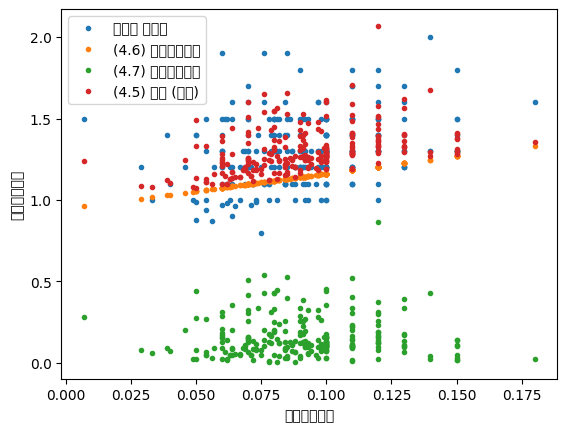

/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:164: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure6{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:164: UserWarning: Glyph 27671 (\N{CJK UNIFIED IDEOGRAPH-6C17}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure6{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:164: UserWarning: Glyph 30001 (\N{CJK UNIFIED IDEOGRAPH-7531}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure6{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:164: UserWarning: Glyph 26469 (\N{CJK UNIFIED IDEOGRAPH-6765}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure6{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:164: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missin

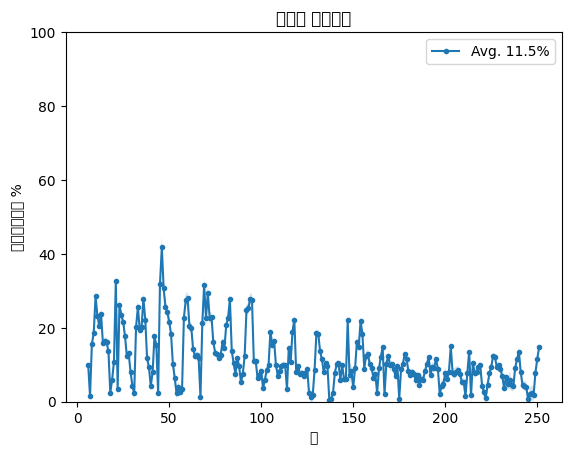

/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:58: UserWarning: Glyph 26690 (\N{CJK UNIFIED IDEOGRAPH-6842}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure3{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:58: UserWarning: Glyph 24029 (\N{CJK UNIFIED IDEOGRAPH-5DDD}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure3{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:58: UserWarning: Glyph 27211 (\N{CJK UNIFIED IDEOGRAPH-6A4B}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure3{panel}.pdf")
/Users/matto/Library/Caches/pypoetry/virtualenvs/km2025-BcinpgeY-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26690 (\N{CJK UNIFIED IDEOGRAPH-6842}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/matto/Library/Caches/pypoetry/virtualenvs/km2025-BcinpgeY-py3.11/lib/python3.11/site-packa

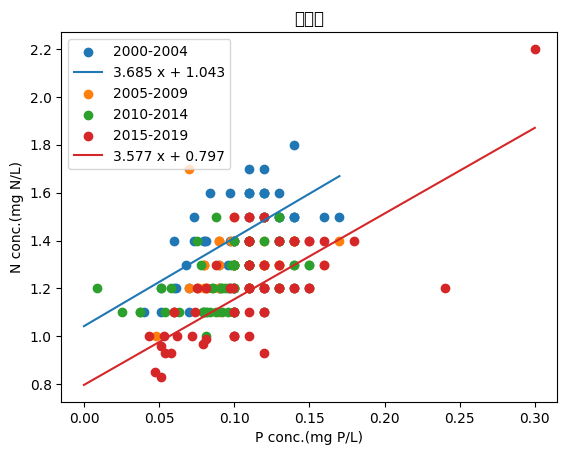

ic| 大気N_delay:                            value  19441030
               datetime                                  
               2000-04-24 13:00:00+09:00    1.6       NaN
               2000-05-11 13:00:00+09:00    1.5       NaN
               2000-06-08 13:00:00+09:00    1.5       NaN
               2000-07-06 13:00:00+09:00    1.5       NaN
               2000-08-03 13:00:00+09:00    1.3       NaN
               ...                          ...       ...
               2021-11-04 09:00:00+09:00    1.2       NaN
               2021-12-02 09:00:00+09:00    1.1       NaN
               2022-01-06 09:00:00+09:00    1.3       NaN
               2022-02-03 09:00:00+09:00    1.2       NaN
               2022-03-03 09:00:00+09:00    1.1       NaN
               
               [264 rows x 2 columns]
ic| B: np.float64(0.1490726734361907)
    a: np.float64(2.3408584908358248)
    b: np.float64(0.949285275703858)
ic| np.corrcoef(crN1, pred): array([[1.        , 0.59605651],
                 

(264,) (264,)


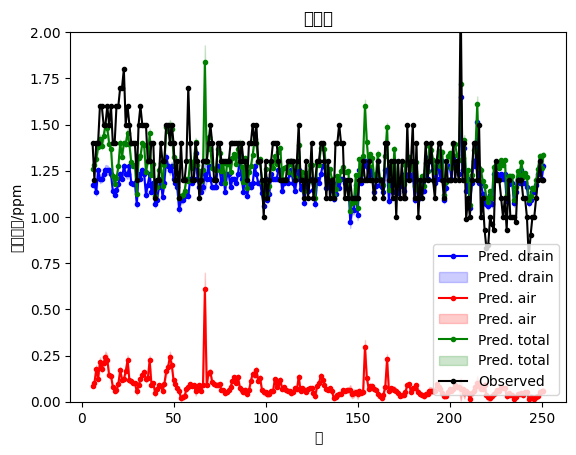

/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:148: UserWarning: Glyph 27827 (\N{CJK UNIFIED IDEOGRAPH-6CB3}) missing from font(s) DejaVu Sans.
  fig.savefig(f"FigureS2{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:148: UserWarning: Glyph 24029 (\N{CJK UNIFIED IDEOGRAPH-5DDD}) missing from font(s) DejaVu Sans.
  fig.savefig(f"FigureS2{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:148: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) DejaVu Sans.
  fig.savefig(f"FigureS2{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:148: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  fig.savefig(f"FigureS2{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:148: UserWarning: Glyph 28611 (\N{CJK UNIFIED IDEOGRAPH-6FC3}) missing from font(s

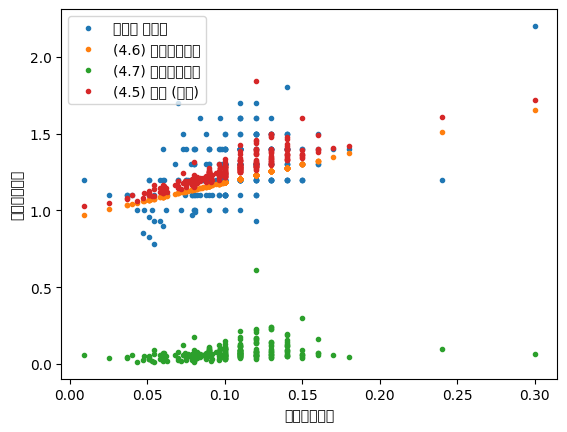

/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:164: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure6{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:164: UserWarning: Glyph 27671 (\N{CJK UNIFIED IDEOGRAPH-6C17}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure6{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:164: UserWarning: Glyph 30001 (\N{CJK UNIFIED IDEOGRAPH-7531}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure6{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:164: UserWarning: Glyph 26469 (\N{CJK UNIFIED IDEOGRAPH-6765}) missing from font(s) DejaVu Sans.
  fig.savefig(f"Figure6{panel}.pdf")
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51110/2817860827.py:164: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missin

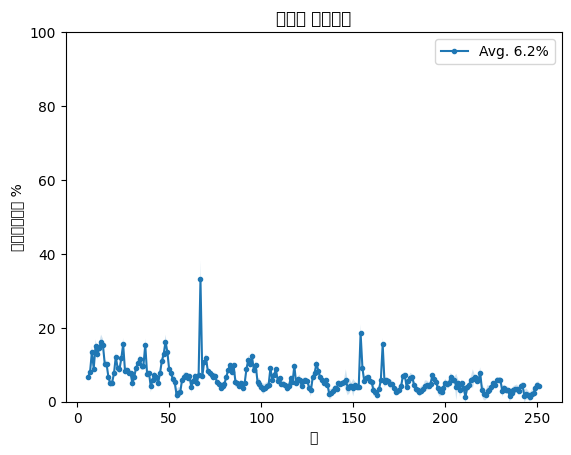

In [19]:
import matplotlib.pyplot as plt
import flow.reader as flow_reader
import datetime as dt
import pytz
from icecream import ic
import numpy as np

panels = {
    "a": dict(flow="昭和橋", air="19202030"),
    "b": dict(flow="大月橋", air="19206010"),
    "c": dict(flow="桂川橋", air="19441030"),
}


for panel, observatory in panels.items():
    obs_flow = observatory["flow"]
    obs_air = observatory["air"]

    #### 大気窒素 ###################################################
    # あらかじめ2つのデータソースを統合したものをnox2とした。
    #

    #### 水質と流量 #################################################
    # 一ヶ月に1回しか測定されないデータ。
    #
    river_N = flow_reader.read_river_N(BASEDIR + "flow/data", obs_flow)
    river_P = flow_reader.read_river_P(BASEDIR + "flow/data", obs_flow)
    river_flow = flow_reader.read_river_flow(BASEDIR + "flow/data", obs_flow)

    # -------------------------------------------------------------
    # 川のN/P比の時間変化
    fig = plt.figure()
    for i, (ys, ye) in enumerate(
        ((2000, 2004), (2005, 2009), (2010, 2014), (2015, 2019))
    ):
        NP = pd.concat([river_N, river_P], axis=1)
        NP.columns = ("N", "P")
        ra = (NP.index > dt.datetime(ys, 1, 1, tzinfo=pytz.timezone("Asia/Tokyo"))) & (
            NP.index < dt.datetime(ye, 12, 31, tzinfo=pytz.timezone("Asia/Tokyo"))
        )
        NP = NP[ra]
        NP = NP.dropna()
        # ic(NP)
        pl = plt.scatter(NP.P, NP.N, color=f"C{i}", label=f"{ys}-{ye}")
        plt.title(obs_flow)
        if ys in (2000, 2015):
            (AA, BB), pcov = scipy.optimize.curve_fit(
                lambda x, A, B: A * x + B, NP.P, NP.N
            )
            X = np.linspace(0, NP.P.max(), 100)
            Y = AA * X + BB
            plt.plot(X, Y, "-", color=f"C{i}", label=f"{AA:.3f} x + {BB:.3f}")

    plt.xlabel("P conc.(mg P/L)")
    plt.ylabel("N conc.(mg N/L)")
    plt.legend()
    fig.savefig(f"Figure3{panel}.pdf")
    plt.show()
    # -------------------------------------------------------------

    #### 雨量 ######################################################
    # あらかじめ読んであるデータを用いる。
    # 気象庁データではない場合、欠測が多い。でも気象庁データは大月しかない。
    #

    大気N_delay = pd.merge(river_N, nox3[obs_air], on="datetime", how="left")
    ic(大気N_delay)

    wc = 大気N_delay.to_numpy()[:, -1]
    crN = river_N.value
    crP = river_P.value
    Fr = river_flow.value
    print(wc.shape, crN.shape)

    Xy = pd.DataFrame([wc, crP, crN, Fr]).transpose().dropna(axis=0)
    Xy.columns = ["wc", "crP", "crN", "Fr"]

    wc1 = Xy["wc"]
    crP1 = Xy["crP"]
    crN1 = Xy["crN"]
    Fr1 = Xy["Fr"]

    ###############################################################
    w = (wc1, Fr1, crP1)
    popt, pcov = scipy.optimize.curve_fit(
        trend_v4,
        w,
        crN1,
        maxfev=12000,
    )
    B, a, b = popt

    ic(B, a, b)

    # plt.plot(B * wc1 / Fr1, label="dry")
    # plt.plot(C * wcP1 / Fr1, label="wet")
    # plt.plot(C * wcP1_rainy / Fr1, label="0.2 mm/h rain")
    # plt.legend()
    # plt.show()

    # -------------------------------------------------------------
    pred = trend_v4(w, *popt)
    error = prop_of_errors_v4(w, pcov)
    pred_drain = trend_v4(w, 0, a, b)
    error_drain = prop_of_errors_v4(w, pcov)
    pred_air = trend_v4(w, B, 0, 0)
    error_air = prop_of_errors_v4(w, pcov)

    ic(np.corrcoef(crN1, pred))

    # -------------------------------------------------------------
    fig = plt.figure()
    plot_river_content(
        crN1,
        pred,
        error,
        pred_drain,
        error_drain,
        pred_air,
        error_air,
        title=obs_flow,
    )
    fig.savefig(f"Figure5{panel}.pdf")
    plt.show()
    # -------------------------------------------------------------

    ###############################################################

    # -------------------------------------------------------------

    fig = plt.figure()
    # plot raw
    plt.plot(crP1, crN1, ".", label=f"{obs_flow} 観測値")

    # plot eq (4.6)
    plt.plot(crP1, pred_drain, ".", label="(4.6) 排水由来成分")

    # plot eq (4.7)
    plt.plot(crP1, pred_air, ".", label="(4.7) 大気由来成分")

    # plot eq (4.5)
    plt.plot(crP1, pred, ".", label="(4.5) 合計 (回帰)")

    plt.xlabel("河川リン濃度")
    plt.ylabel("河川窒素濃度")
    plt.legend()
    fig.savefig(f"FigureS2{panel}.pdf")
    plt.show()
    # -------------------------------------------------------------

    # 成分比 #######################################################

    # -------------------------------------------------------------
    fig = plt.figure()
    plot_river_composition(
        pred,
        error,
        pred_air,
        error_air,
        title=f"{obs_flow} 大気由来",
    )
    plt.legend()
    fig.savefig(f"Figure6{panel}.pdf")
    plt.show()
    # -------------------------------------------------------------

# Figure 1


In [ ]:
from shapely.ops import unary_union
import geopandas as gpd


regions = """83032	40		
83032	41
83032	42
83032	43
83032	44
83032	45
83032	46
83032	47
83032	48
83032	49
83032	50
83032	51
83032	52
83032	53
83032	54	秋山川	Y-9
83032	55	秋山川	Y-9
83032	56	秋山川	Y-9
83032	57	秋山川	Y-9
83032	58	秋山川	Y-9
83032	59	秋山川	Y-9
83032	60	秋山川	Y-9
83032	61	秋山川	Y-9
83032	62	秋山川	Y-9
83032	63	秋山川	Y-9
83032	64
83032	65
83032	66	境川
83032	67		Y-7
83032	68		Y-7
83032	69		Y-7
83032	70	鶴川	Y-7
83032	71	鶴川	Y-7
83032	72	鶴川	Y-7
83032	73	鶴川	Y-7
83032	74	鶴川	Y-7
83032	75		Y-7
83032	76		Y-7
83032	77	?
83032	78		Y-7
83032	79		Y-7
83032	80	葛野川	Y-7
83032	81	?	Y-6
83032	82	朝日川	Y-6
83032	83	朝日川	Y-6
83032	84	道志川
83032	85		Y-7
83032	86		Y-7
83032	87	葛野川	Y-7
83032	88	葛野川	Y-7
83032	89	葛野川	Y-7
83032	90	葛野川	Y-7
83032	91	葛野川	Y-7
83032	92	葛野川	Y-7
83032	93	葛野川	Y-7
83032	94	葛野川	Y-7
83032	95	?	Y-7
83032	96	?	Y-7
83032	97		Y-7
83032	98	笹子川	Y-7
83032	99	笹子川	Y-7
83032	100	笹子川	Y-7
83032	101	笹子川	Y-7
83032	102	笹子川	Y-7
83032	103	笹子川	Y-7
83032	104	笹子川	Y-7
83032	105	笹子川	Y-7
83032	106	笹子川	Y-7
83032	107	笹子川	Y-7
83032	108		Y-6
83032	109		Y-6
83032	110		Y-6
83032	111		Y-6
83032	112		Y-6
83032	113	朝日川	Y-6
83032	114	朝日川	Y-6
83032	115	(朝日川)	Y-6
83032	116	(朝日川)	Y-6
83032	117	(朝日川)	Y-6
83032	118	(朝日川)	Y-6
83032	119	(朝日川)	Y-6
83032	120	(朝日川)	Y-6
83032	121		Y-5
83032	122	大幡川	Y-5
83032	123	大幡川	Y-5
83032	124	?	Y-5
83032	125	?	Y-5
83032	126	柄杓流川	Y-5
83032	127	柄杓流川	Y-5
83032	128	柄杓流川	Y-5
83032	129	柄杓流川	Y-5
83032	130	柄杓流川	Y-5
83032	131		Y-6
83032	132	鹿留川	Y-6
83032	133	鹿留川	Y-6
83032	134	鹿留川	Y-6
83032	135	鹿留川	Y-6
83032	136		Y-4
83032	137		Y-4
83032	138		Y-4
83032	139		Y-4
83032	140		Y-4
83032	141
83032	142		Y-2
83032	143
83032	144
83032	145
83032	146	宮川	Y-2
83032	147		Y-4
83032	148		Y-4
83032	149		Y-4
83032	150		Y-4
83032	151		Y-4
83032	152		Y-4
83032	153		Y-4
83032	154		Y-4
83032	155		Y-4
83032	156		Y-1
83032	157		Y-1
83032	158		Y-1
83032	159		Y-1
83032	160		Y-1
83032	161	宮川	Y-2
83032	162	宮川	Y-2
83032	163	宮川	Y-2
83032	164	宮川	Y-2
83032	165	宮川	Y-2
83032	166	宮川	Y-2
83032	167		Y-4
83032	168	笹子川	Y-7
83032	169	柄杓流川	Y-5
83953	1		Y-2
83953	2		Y-2
83953	3		Y-2
83953	4		Y-2
83953	5		Y-2
83953	6		Y-2
83953	7		Y-2
83953	8		Y-2
83954	1		Y-2
83954	2		Y-2
""".splitlines()

regions = [line.split("\t") for line in regions]
regions = {(f"{b[0]}", f"{int(b[1]):04d}"): b[3] for b in regions if len(b) == 4}


神奈川shape = f"basin/data/W12-52A-14-01.1_GML/W12-52A_14_WatershedBoundary.shp"
神奈川basin = gpd.read_file(神奈川shape, engine="fiona")
山梨shape = f"basin/data/W12-52A-19-01.1_GML/W12-52A_19_WatershedBoundary.shp"
山梨basin = gpd.read_file(山梨shape, engine="fiona")
basin = pd.concat([山梨basin, 神奈川basin], axis=0, ignore_index=True)
basin


神奈川shape = f"basin/data/W05-08_14_GML/W05-08_14-g_Stream.shp"
神奈川branch = gpd.read_file(神奈川shape)
山梨shape = f"basin/data/W05-08_19_GML/W05-08_19-g_Stream.shp"
山梨branch = gpd.read_file(山梨shape)
branch = pd.concat([山梨branch, 神奈川branch], axis=0, ignore_index=True)


import json

with open("air/stations.json", "r") as f:
    stations_loc = json.load(f)
stations_loc

# Shapefileを読み込む
fp = "basin/data/kanagawa/N03-20_14_200101.shp"
kanagawa = gpd.read_file(fp, encoding="cp932")
fp = "basin/data/yamanashi/N03-20_19_200101.shp"
yamanashi = gpd.read_file(fp, encoding="cp932")

polygons = yamanashi["geometry"]
yb = gpd.GeoSeries(unary_union(polygons))
# yb.plot(color="red")

polygons = kanagawa["geometry"]
kb = gpd.GeoSeries(unary_union(polygons))
# kb.plot(color="blue")
# plt.show()

bridges = {
    "Katsuragawa Br.": (35.6167306, 139.1171345),  #
    # "境川橋": (35.61726232577428, 139.13838232748358),  #
    "Ohtsuki Br.": (35.60887308, 138.93663348),
    # "富士見橋": (35.52293, 138.84808),  # 35.52293、138.84808
    "Showa Br.": (35.49653, 138.80937),
    "Sagami Lake": (35 + 36 / 60 + 43 / 3600, 139 + 11 / 60 + 3 / 3600),
}

basins = ["83032", "83953", "83954"]  # 相模川、河口湖、西湖
colors = ["#dfd", "#fdd", "#ddd"]

bcolors = {
    "Y-2": "red",
    "Y-3": "red",
    "Y-1": "orange",
    "Y-4": "orange",
    "Y-5": "yellow",
    "Y-6": "yellow",
    "Y-7": "lime",
}


blocks = dict()
for (b, region), regionname in regions.items():
    # print(b, region, regionname)
    if regionname in bcolors:
        color = bcolors[regionname]
    else:
        color = "gray"
    if color not in blocks:
        blocks[color] = []
    sub = basin[(basin["W12_002"] == b) & (basin["W12_003"] == region)]
    blocks[color].append(sub["geometry"])
    # sub["geometry"].plot(ax=ax1, color=bcolors[regionname])
    # basin[basin["W12_002"]==b & basin["W12_003"]==region]["geometry"].boundary.plot(ax=ax1, color="#fff")

blocks = {color: pd.concat(block) for color, block in blocks.items()}

# 流域ブロックを塗る。
# blockは辞書。キーは色、値は下の地図の領域を表す。
# for color, block in blocks.items():
#     block.plot(color=color, ax=ax1)
#     # block.to_file(f"{color}.geojson", driver="GeoJSON")


# 大気測定局
stations = {"19202030": "Yoshida", "19206010": "Ohtsuki", "19441030": "Uenohara"}

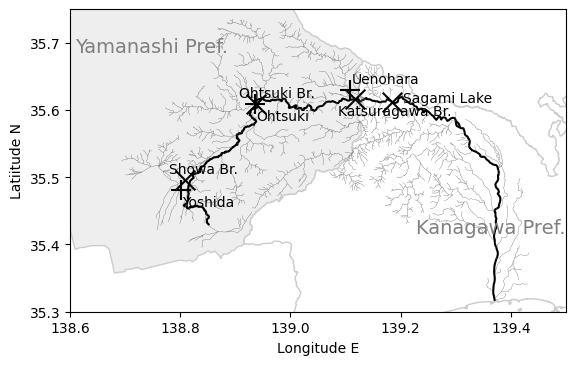

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()


# 県の輪郭線を描く

yb.plot(ax=ax1, edgecolor="#ccc", facecolor="#eee", linewidth=1)
kb.plot(ax=ax1, edgecolor="#ccc", facecolor="white", linewidth=1)
県名, 輪郭 = "Yamanashi Pref.", yb
center = 輪郭.centroid[0]
ax1.annotate(県名, (center.x, center.y + 0.07), size=14, color="gray")
県名, 輪郭 = "Kanagawa Pref.", kb
center = 輪郭.centroid[0]
ax1.annotate(県名, (center.x - 0.11, center.y), size=14, color="gray")


# 相模川全線を描く。
sagami = branch[branch["W05_001"].str.contains("830307")]
sagami.plot(ax=ax1, color="#444", linewidth=0.2)

branch[branch["W05_004"].str.contains("相模川")].loc[:, "geometry"].plot(
    ax=ax1, color="black", label="Sagami river"
)

# 流末測定点
markersX = []
markersY = []
for b, p in bridges.items():
    markersX.append(p[1])
    markersY.append(p[0])
    yoffset = +0.01
    xoffset = -0.03
    if b in ("Sagami Lake",):
        xoffset = +0.02
        yoffset = 0
    elif b in ("Katsuragawa Br.",):
        yoffset = -0.025
    ax1.annotate(
        b,
        (p[1] + xoffset, p[0] + yoffset),
        #  size=24,
        color="k",
    )
ax1.scatter(markersX, markersY, marker="x", color="k", s=200)


for station, ename in stations.items():
    yoffset = +0.01
    if station in ("19202030", "19206010"):
        yoffset = -0.024
    ax1.annotate(
        ename,
        # stations_loc[station]["name"],
        (
            stations_loc[station]["longitude"] + 0.002,
            stations_loc[station]["latitude"] + yoffset,
        ),
        # size=24,
        color="k",
    )
    ax1.scatter(
        stations_loc[station]["longitude"],
        stations_loc[station]["latitude"],
        marker="+",
        color="k",
        s=200,
    )


# ax1.s91/111
ax1.set_xlim(138.6, 139.5)
ax1.set_ylim(35.3, 35.75)
# ax1.legend()
ax1.set_aspect(111 / 91)
ax1.set_xlabel("Longitude E")
ax1.set_ylabel("Latitude N")

fig.savefig("Figure1.pdf")